In [23]:
# python library imports
import pandas as pd
import glob
import numpy as np
import sys
from sklearn.model_selection import train_test_split
import sagemaker
import os
import boto3

In [24]:
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker.Session().default_bucket()

prefix = 'ipinyou'
os.environ["AWS_REGION"] = region

print(f'Region : {region}')
print(f'IAM Role : {role}')
print(f'S3 Bucket : {bucket_name}')

# Get the current installed version of Sagemaker SDK, TensorFlow, Python, Boto3 and SMDebug
print(f'SageMaker Python SDK version : {sagemaker.__version__}')
print(f'Python version : {sys.version}')

Region : us-east-1
IAM Role : arn:aws:iam::725069941408:role/service-role/AmazonSageMaker-ExecutionRole-20230327T095833
S3 Bucket : sagemaker-us-east-1-725069941408
SageMaker Python SDK version : 2.145.0
Python version : 3.10.10 (main, Apr 10 2023, 18:44:18) [GCC 9.4.0]


In [25]:
df = pd.read_csv('usersegfull.csv',header=None)

In [26]:
df

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,1,94,95,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,58,100,240
1,1,124,129,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,175,43,146
2,1,80,85,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,221,224,27
3,1,298,299,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,114,138,135
4,1,2,2,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,222,36,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216882,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,39,11,110
216883,0,276,279,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,110,190,227
216884,0,216,227,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,121,15,253
216885,0,40,44,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,113,239,254


In [27]:
# Install TensorFlow Decision Forests.
%pip install tensorflow_decision_forests --upgrade


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
%pip install wurlitzer -q


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
%pip install protobuf==3.20.3 -q


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Imports

In [30]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import sagemaker
import boto3
import sys

In [31]:
tf.__version__

'2.12.0'

In [32]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)


Found TensorFlow Decision Forests v1.3.0


## Local

In [12]:
# data
df

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,1,94,95,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,58,100,240
1,1,124,129,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,175,43,146
2,1,80,85,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,221,224,27
3,1,298,299,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,114,138,135
4,1,2,2,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,222,36,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216882,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,39,11,110
216883,0,276,279,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,110,190,227
216884,0,216,227,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,121,15,253
216885,0,40,44,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,113,239,254


In [13]:
df.columns = df.columns.astype(str)

In [14]:
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=54321), [int(0.7 * len(df)), int(0.9 * len(df))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%

In [15]:
test_data

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
30665,1,146,148,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,120,128,7
121463,0,3,7,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,60,5,84
20539,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,231,53,51
10418,1,2,2,1,1,0,1,1,1,1,...,0,0,1,0,0,0,0,222,36,115
870,1,183,189,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,61,184,206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155726,0,146,159,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,112,251,101
20576,1,79,79,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,180,166,42
195610,0,106,107,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,101,46,11
70282,1,298,300,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,206,6


In [187]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data,label='0')
val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(validation_data, label='0')

In [22]:
train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
count,151820.000000,151820.000000,151820.000000,151820.000000,151820.000000,151820.000000,151820.000000,151820.000000,151820.000000,151820.000000,...,151820.000000,151820.000000,151820.000000,151820.000000,151820.000000,151820.000000,151820.000000,151820.000000,151820.000000,151820.000000
mean,0.473976,149.378409,154.281913,0.656837,0.284758,0.171552,0.084324,0.147774,0.221875,0.555869,...,0.247695,0.000606,0.093156,0.001159,0.001541,0.002108,0.001765,128.504868,125.673765,124.270689
std,0.499324,103.797224,104.980973,0.474767,0.451301,0.376992,0.277873,0.354877,0.415509,0.496871,...,0.431675,0.024609,0.290652,0.034028,0.039229,0.045862,0.041978,57.564273,74.039152,73.763240
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,79.000000,79.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,111.000000,64.000000,60.000000
50%,0.000000,146.000000,148.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,119.000000,122.000000,124.000000
75%,1.000000,216.000000,223.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,191.000000,187.000000
max,1.000000,395.000000,399.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,255.000000


In [189]:
train_ds

<_PrefetchDataset element_spec=({'1': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '2': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '3': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '4': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '5': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '6': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '7': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '8': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '9': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '10': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '11': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '12': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '13': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '14': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '15': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '16': TensorSpec(shape=(None,), dtype=tf.int64, name=None), '17': TensorSpec

In [192]:
for batch, (images, labels) in enumerate(test_ds.take(1)):
    print(batch)
    print(images)
    print(labels)

0
{'1': <tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([216,  80, 238, 216,  79, 164, 164,   1, 325, 374,   2, 216,  80,
       124, 276, 333, 276,   0,  94,  80, 146,   1,  80,  80, 298, 124,
        65, 276,  79, 183, 146, 183,  94, 333, 216,  94, 106,  40, 253,
       216,  80,   1, 333, 216,  94,  80, 146, 146, 106,  65, 216,   3,
       146,   1, 134,  79, 216,  80, 276,  40,  27,   3, 216, 216, 344,
       395,  80,  27,  79,  15, 333, 134,  15, 164, 134,   2,  79, 146,
       276,  80, 124, 216,  80, 216, 359,  15, 216, 146,   2, 275, 238,
       183, 146, 393,   3, 183, 164, 134, 216, 216,  15, 238,  80, 216,
        80, 216, 276,   0, 216, 216, 276, 374,  65, 216, 216,  79,  27,
       201, 216, 216,   0, 216,  80, 183,  80, 164, 164, 216, 276,   0,
       146, 216,  15,  80, 253, 216,  94,   3,  79, 106, 216, 238,  94,
         3, 146,  65, 374, 308,  80, 276,  40, 134, 308, 183,  27,  80,
       124, 333, 183, 124,  40,  94,  80,   1, 146,   1,  94, 216, 124,
        9

2023-06-01 15:24:39.945134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int64 and shape [43378]
	 [[{{node Placeholder/_8}}]]


In [19]:
# Specify the model.
model_1 = tfdf.keras.RandomForestModel(verbose=2)

# Train the model.
model_1.fit(train_ds)

Use 8 thread(s) for training
Use /tmp/tmpyemfpcpy as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'1': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, '2': <tf.Tensor 'data_1:0' shape=(None,) dtype=int64>, '3': <tf.Tensor 'data_2:0' shape=(None,) dtype=int64>, '4': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, '5': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, '6': <tf.Tensor 'data_5:0' shape=(None,) dtype=int64>, '7': <tf.Tensor 'data_6:0' shape=(None,) dtype=int64>, '8': <tf.Tensor 'data_7:0' shape=(None,) dtype=int64>, '9': <tf.Tensor 'data_8:0' shape=(None,) dtype=int64>, '10': <tf.Tensor 'data_9:0' shape=(None,) dtype=int64>, '11': <tf.Tensor 'data_10:0' shape=(None,) dtype=int64>, '12': <tf.Tensor 'data_11:0' shape=(None,) dtype=int64>, '13': <tf.Tensor 'data_12:0' shape=(None,) dtype=int64>, '14': <tf.Tensor 'data_13:0' shape=(None,) dtype=int64>, '15': <tf.Tensor 'data_14:0' shape=(None,) dtype=int64>, '16': <tf.Tensor 'd

[INFO 23-04-27 18:26:35.5070 UTC kernel.cc:773] Start Yggdrasil model training
[INFO 23-04-27 18:26:35.5070 UTC kernel.cc:774] Collect training examples
[INFO 23-04-27 18:26:35.5071 UTC kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-04-27 18:26:35.5076 UTC kernel.cc:393] Number of batches: 152
[INFO 23-04-27 18:26:35.5076 UTC kernel.cc:394] Number of examples: 151820
[INFO 23-04-27 18:26:35.5727 UTC kernel.cc:794] Training dataset:
Number of records: 151820
Number of columns: 49

Number of columns by type:
	NUMERICAL: 48 (97.9592%)
	CATEGORICAL: 1 (2.04082%)

Columns:

NUMERICAL: 48 (97.9592%)
	0: "1" NUMERICAL mean:149.378 min:0 max:395 sd:10

Model trained in 0:00:21.494091
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [ ]:
# deep neural network

In [ ]:
from tensorflow.keras.layers.

In [65]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, Concatenate
from keras.layers.merging import concatenate

# Define the number of dimensions for the embedding layer
embedding_dims = 20

# Add the input layers city and region 
input1 = Input(shape=(2,))
emb1 = Embedding(input_dim=400, output_dim=embedding_dims)(input1)
flat1 = Flatten()(emb1)
                
# for one hot encoded features
input2 = Input(shape=(43,))
emb2 = Embedding(input_dim=2, output_dim=embedding_dims)(input2)
flat2 = Flatten()(emb2)

# for ip addresses
input3 = Input(shape=(3,))
emb3 = Embedding(input_dim=256, output_dim=embedding_dims)(input3)
flat3 = Flatten()(emb3)

# Merge the inputs
merged_layer = Concatenate()([flat1, flat2, flat3])

# Add the output layer
dense1 = Dense(256, activation='relu')(merged_layer)
dense2 = Dense(64, activation='relu')(dense1)
output_layer = Dense(1, activation='sigmoid')(dense2)

model = Model(inputs=[input1, input2, input3], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [66]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 43)]         0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 2, 20)        8000        ['input_25[0][0]']               
                                                                                            

In [67]:
train_data.iloc[:,1:].values.shape

(151820, 48)

In [68]:
train_data.iloc[:,0].values.shape

(151820,)

In [69]:
train_data.iloc[:,46:]

,46,47,48
119922,123,156,20
158005,211,142,116
17399,120,6,36
174551,124,72,184
24635,27,24,160
...,...,...,...
41515,1,56,200
163648,121,15,253
90060,222,129,52
6560,114,221,249


In [78]:
model.evaluate(x = [validation_data.iloc[:,1:3].values, validation_data.iloc[:,3:46].values, validation_data.iloc[:,46:].values], y = validation_data.iloc[:,0].values)

1356/1356 [==============================] - 2s 1ms/step - loss: 0.1415 - accuracy: 0.9634


[0.14149637520313263, 0.9634146094322205]

In [70]:
model.fit(x = [train_data.iloc[:,1:3].values, train_data.iloc[:,3:46].values, train_data.iloc[:,46:].values], y = train_data.iloc[:,0].values, batch_size=256, epochs=10, validation_split=0.2)

Epoch 1/10
475/475 [==============================] - 3s 5ms/step - loss: 0.1613 - accuracy: 0.9532 - val_loss: 0.1334 - val_accuracy: 0.9633
Epoch 2/10
475/475 [==============================] - 2s 5ms/step - loss: 0.1350 - accuracy: 0.9625 - val_loss: 0.1325 - val_accuracy: 0.9633
Epoch 3/10
475/475 [==============================] - 2s 5ms/step - loss: 0.1339 - accuracy: 0.9625 - val_loss: 0.1331 - val_accuracy: 0.9633
Epoch 4/10
475/475 [==============================] - 2s 5ms/step - loss: 0.1333 - accuracy: 0.9625 - val_loss: 0.1333 - val_accuracy: 0.9633
Epoch 5/10
475/475 [==============================] - 2s 5ms/step - loss: 0.1329 - accuracy: 0.9625 - val_loss: 0.1341 - val_accuracy: 0.9633
Epoch 6/10
475/475 [==============================] - 2s 5ms/step - loss: 0.1324 - accuracy: 0.9625 - val_loss: 0.1349 - val_accuracy: 0.9633
Epoch 7/10
475/475 [==============================] - 2s 5ms/step - loss: 0.1315 - accuracy: 0.9625 - val_loss: 0.1357 - val_accuracy: 0.9633
Epoch 

# Use SageMaker

In [13]:
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker.Session().default_bucket()

prefix = 'ipinyou'
os.environ["AWS_REGION"] = region

print(f'Region : {region}')
print(f'IAM Role : {role}')
print(f'S3 Bucket : {bucket_name}')

# Get the current installed version of Sagemaker SDK, TensorFlow, Python, Boto3 and SMDebug
print(f'SageMaker Python SDK version : {sagemaker.__version__}')
print(f'Python version : {sys.version}')

Region : us-east-1
IAM Role : arn:aws:iam::725069941408:role/service-role/AmazonSageMaker-ExecutionRole-20230327T095833
S3 Bucket : sagemaker-us-east-1-725069941408
SageMaker Python SDK version : 2.145.0
Python version : 3.8.13 (default, Mar 28 2022, 11:38:47) 
[GCC 7.5.0]


In [14]:
sagemaker_session.upload_data('train.csv',bucket=bucket_name,key_prefix=prefix)
sagemaker_session.upload_data('val.csv',bucket=bucket_name,key_prefix=prefix)
sagemaker_session.upload_data('test.csv',bucket=bucket_name,key_prefix=prefix)

's3://sagemaker-us-east-1-725069941408/ipinyou/test.csv'

In [39]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket_name}/{prefix}/train.csv', content_type='csv',)
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket_name}/{prefix}/val.csv', content_type='csv')
s3_input_test = sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket_name}/{prefix}/test.csv', content_type='csv')

## TF Decision Forest

In [49]:
from sagemaker.tensorflow import TensorFlow

tfdf_estimator = TensorFlow(
    source_dir="code",
    entry_point="tf-decision-forest.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    framework_version="2.9.1",
    py_version="py39",
    tags=[{"Key":"task","Value":"look-a-like"},
          {"Key":"algo","Value":"tfdf"},
          {"Key":"team","Value":"aws"}]
)

In [50]:
tfdf_estimator.fit({'train':s3_input_train,'test':s3_input_validation})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-05-01-20-37-20-784


2023-05-01 20:37:21 Starting - Starting the training job...
2023-05-01 20:37:37 Starting - Preparing the instances for training...
2023-05-01 20:38:19 Downloading - Downloading input data...
2023-05-01 20:38:44 Training - Downloading the training image...
2023-05-01 20:39:30 Training - Training image download completed. Training in progress...2023-05-01 20:39:37.566702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 20:39:37.667403: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-05-01 20:39:37.667566: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future rec

## Neural Network with Embedding

In [17]:
from sagemaker.tensorflow import TensorFlow

dnn_estimator = TensorFlow(
    source_dir="code",
    entry_point="tf-deep-nn.py",
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    framework_version="2.11",
    py_version="py39",
    metric_definitions = [
        {"Name": "test_accuracy", "Regex": "Test Accuracy: ([0-9.]+)"}
    ],
    tags=[{"Key":"task","Value":"look-a-like"},
          {"Key":"algo","Value":"deep-nn-embedding"},
          {"Key":"team","Value":"aws"}], 
)

dnn_estimator.fit({'train':s3_input_train,'test':s3_input_validation})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-05-01-20-07-25-812


2023-05-01 20:07:26 Starting - Starting the training job...
2023-05-01 20:07:42 Starting - Preparing the instances for training...
2023-05-01 20:08:22 Downloading - Downloading input data...
2023-05-01 20:08:42 Training - Downloading the training image...
2023-05-01 20:09:32 Training - Training image download completed. Training in progress..2023-05-01 20:09:39.289357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 20:09:39.395917: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-05-01 20:09:39.396082: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future reco

## Distributed Training

In [87]:
from sagemaker.tensorflow import TensorFlow

dnn_estimator = TensorFlow(
    source_dir="code",
    entry_point="tf-deep-nn-distributed-mirror.py",
    role=role,
    instance_count=1,
    instance_type="ml.p3.16xlarge",
    framework_version="2.9.2",
    py_version="py39",
    metric_definitions = [
        {"Name": "test_accuracy", "Regex": "Test Accuracy: ([0-9.]+)"}
    ],
    tags=[{"Key":"task","Value":"look-a-like"},
          {"Key":"algo","Value":"deep-nn-embedding"},
          {"Key":"team","Value":"aws"}], 
)

dnn_estimator.fit({'train':s3_input_train,'test':s3_input_validation})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-06-05-19-50-38-064


2023-06-05 19:50:39 Starting - Starting the training job......
2023-06-05 19:51:32 Starting - Preparing the instances for training.........
2023-06-05 19:53:12 Downloading - Downloading input data
2023-06-05 19:53:12 Training - Downloading the training image.....................
2023-06-05 19:56:38 Training - Training image download completed. Training in progress...2023-06-05 19:57:02.921470: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-06-05 19:57:02.921690: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2023-06-05 19:57:02.967317: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-06-05 19:57:05,471 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2023-06-05 19:57:06,069 sagemaker-train

## SageMaker Search

In [51]:
search_params={
   "MaxResults": 10,
   "Resource": "TrainingJob",
   "SearchExpression": { 
      "Filters": [{ 
            "Name": "Tags.task",
            "Operator": "Equals",
            "Value": "look-a-like"
         }, 
          { 
            "Name": "TrainingJobStatus",
            "Operator": "Equals",
            "Value": "Completed"
         },
      ]},
  "SortBy": "Metrics.test_accuracy",
  "SortOrder": "Descending"
}

smclient = boto3.client(service_name='sagemaker')
results = smclient.search(**search_params)

In [52]:
results['Results']

[{'TrainingJob': {'TrainingJobName': 'tensorflow-training-2023-05-01-19-22-02-275',
   'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:725069941408:training-job/tensorflow-training-2023-05-01-19-22-02-275',
   'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-725069941408/tensorflow-training-2023-05-01-19-22-02-275/output/model.tar.gz'},
   'TrainingJobStatus': 'Completed',
   'SecondaryStatus': 'Completed',
   'HyperParameters': {'model_dir': '"s3://sagemaker-us-east-1-725069941408/tensorflow-training-2023-05-01-19-22-02-275/model"',
    'sagemaker_container_log_level': '20',
    'sagemaker_job_name': '"tensorflow-training-2023-05-01-19-22-02-275"',
    'sagemaker_program': '"tf-deep-nn.py"',
    'sagemaker_region': '"us-east-1"',
    'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-725069941408/tensorflow-training-2023-05-01-19-22-02-275/source/sourcedir.tar.gz"'},
   'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/tenso

In [53]:
out = []
header = ['Name', 'Status', 'Accuracy', 'Duration', 'StartTime', 'EndTime']
for r in results['Results']:
    trainingJob = r['TrainingJob']
   
    if 'FinalMetricDataList' in trainingJob:
        metrics = trainingJob['FinalMetricDataList']
        mout = metrics[0]['Value']
    else:
        mout = "unknown"
    out.append([
        trainingJob['TrainingJobName'],
        trainingJob['TrainingJobStatus'],
        mout,
        trainingJob['TrainingTimeInSeconds'],
        trainingJob['TrainingStartTime'],
        trainingJob['TrainingEndTime']])
    
df = pd.DataFrame(data=out,columns=header)

In [54]:
df

,Name,Status,Accuracy,Duration,StartTime,EndTime
0,tensorflow-training-2023-05-01-19-22-02-275,Completed,0.96538,182,2023-05-01 19:23:03+00:00,2023-05-01 19:26:05+00:00
1,tensorflow-training-2023-05-01-20-07-25-812,Completed,0.96537,182,2023-05-01 20:08:21+00:00,2023-05-01 20:11:23+00:00
2,tensorflow-training-2023-05-01-15-30-43-888,Completed,0.96537,182,2023-05-01 15:31:45+00:00,2023-05-01 15:34:47+00:00
3,tensorflow-training-2023-05-01-20-37-20-784,Completed,unknown,197,2023-05-01 20:38:19+00:00,2023-05-01 20:41:36+00:00
4,tensorflow-training-2023-05-01-15-06-30-773,Completed,unknown,192,2023-05-01 15:07:30+00:00,2023-05-01 15:10:42+00:00
5,tensorflow-training-2023-05-01-14-51-39-023,Completed,unknown,188,2023-05-01 14:52:39+00:00,2023-05-01 14:55:47+00:00


## Profile

In [22]:
!pip install smdebug #jinja2==3.0


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [23]:
from smdebug.profiler.system_metrics_reader import S3SystemMetricsReader

path = dnn_estimator.latest_job_profiler_artifacts_path()
system_metrics_reader = S3SystemMetricsReader(path)

sagemaker_client = boto3.client("sagemaker")
training_job_name = dnn_estimator.latest_training_job.name
print(f"Training job name: {training_job_name}")

[2023-05-01 20:12:39.534 sagemaker-data-scienc-ml-t3-medium-5812005f1de07e20cb211bb2dcf1:84 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
Training job name: tensorflow-training-2023-05-01-20-07-25-812


In [25]:
training_job_status = ""
training_job_secondary_status = ""
while system_metrics_reader.get_timestamp_of_latest_available_file() == 0:
    system_metrics_reader.refresh_event_file_list()
    client = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
    if "TrainingJobStatus" in client:
        training_job_status = f"TrainingJobStatus: {client['TrainingJobStatus']}"
    if "SecondaryStatus" in client:
        training_job_secondary_status = f"TrainingJobSecondaryStatus: {client['SecondaryStatus']}"

    print(
        f"Profiler data from system not available yet. {training_job_status}. {training_job_secondary_status}."
    )
    time.sleep(20)

print("\n\nProfiler data from system is available", dnn_estimator.latest_job_profiler_artifacts_path())



Profiler data from system is available s3://sagemaker-us-east-1-725069941408/tensorflow-training-2023-05-01-20-07-25-812/profiler-output


In [35]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
tj = TrainingJob(dnn_estimator.latest_training_job.job_name, region)

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-725069941408/', 'ProfilingIntervalInMilliseconds': 500, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-725069941408/tensorflow-training-2023-05-01-20-07-25-812/profiler-output


In [34]:
from smdebug.profiler.analysis.utils.profiler_data_to_pandas import PandasFrame

In [46]:
pf = PandasFrame(tj.profiler_s3_output_path)
system_metrics_df = pf.get_all_system_metrics()
framework_metrics_df = pf.get_all_framework_metrics()

[2023-05-01 20:29:26.248 sagemaker-data-scienc-ml-t3-medium-5812005f1de07e20cb211bb2dcf1:84 INFO algorithm_metrics_reader.py:191] S3AlgorithmMetricsReader created with bucket:sagemaker-us-east-1-725069941408 and prefix:tensorflow-training-2023-05-01-20-07-25-812/profiler-output/framework/


In [37]:
system_metrics_df

,timestamp,timestamp_us,value,system_metric,dimension,nodeID,type
0,2023-05-01T20:08:24:000834,24000834,3.160000e+00,MemoryUsedPercent,,algo-1,memory
1,2023-05-01T20:08:24:500340,24500340,4.423000e+01,cpu2,I/OWaitPercentage,algo-1,cpu
2,2023-05-01T20:08:24:500340,24500340,5.882000e+01,cpu0,CPUUtilization,algo-1,cpu
3,2023-05-01T20:08:24:500340,24500340,2.745000e+01,cpu0,I/OWaitPercentage,algo-1,cpu
4,2023-05-01T20:08:24:500340,24500340,4.792000e+01,cpu1,CPUUtilization,algo-1,cpu
...,...,...,...,...,...,...,...
5420,2023-05-01T20:11:13:500465,193500465,1.066006e+09,WriteThroughputInBytesPerSecond,,algo-1,i/o
5421,2023-05-01T20:11:13:500652,193500652,0.000000e+00,ReceiveBytesPerSecond,Algorithm,algo-1,network
5422,2023-05-01T20:11:13:500652,193500652,0.000000e+00,TransmitBytesPerSecond,Algorithm,algo-1,network
5423,2023-05-01T20:11:13:500652,193500652,2.184170e+03,ReceiveBytesPerSecond,Platform,algo-1,network


<AxesSubplot:xlabel='timestamp'>

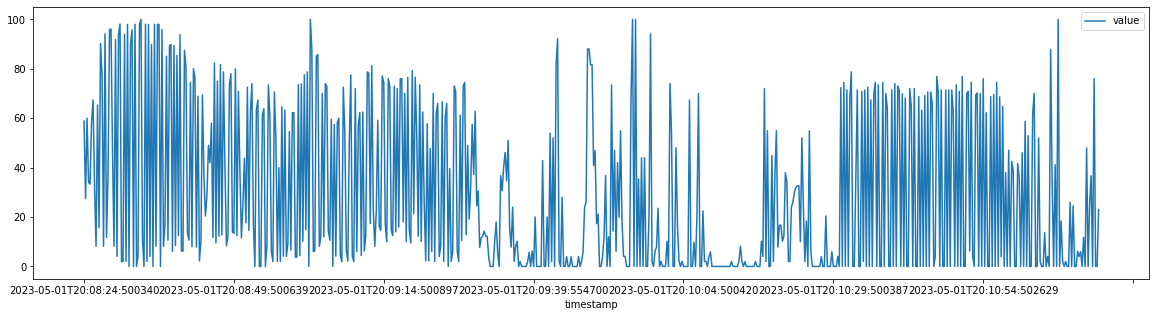

In [44]:
system_metrics_df[system_metrics_df['system_metric']=='cpu0'].plot(x='timestamp',y='value',figsize = (20,5))

In [57]:
system_metrics_df['timestamp'] = pd.to_datetime(system_metrics_df['timestamp'],format="%Y-%m-%dT%H:%M:%S:%f")

In [59]:
system_metrics_df = system_metrics_df.set_index('timestamp')

In [61]:
df = system_metrics_df[system_metrics_df['system_metric']=='cpu0']['value']

In [62]:
df

timestamp
2023-05-01 20:08:24.500340    58.82
2023-05-01 20:08:24.500340    27.45
2023-05-01 20:08:25.000266    60.00
2023-05-01 20:08:25.000266    34.00
2023-05-01 20:08:25.500335    33.33
                              ...  
2023-05-01 20:11:12.500410     0.00
2023-05-01 20:11:13.000397    76.00
2023-05-01 20:11:13.000397     0.00
2023-05-01 20:11:13.500396     0.00
2023-05-01 20:11:13.500396    22.92
Name: value, Length: 678, dtype: float64

In [63]:
df_re = df.resample('2S').mean()

<AxesSubplot:xlabel='timestamp'>

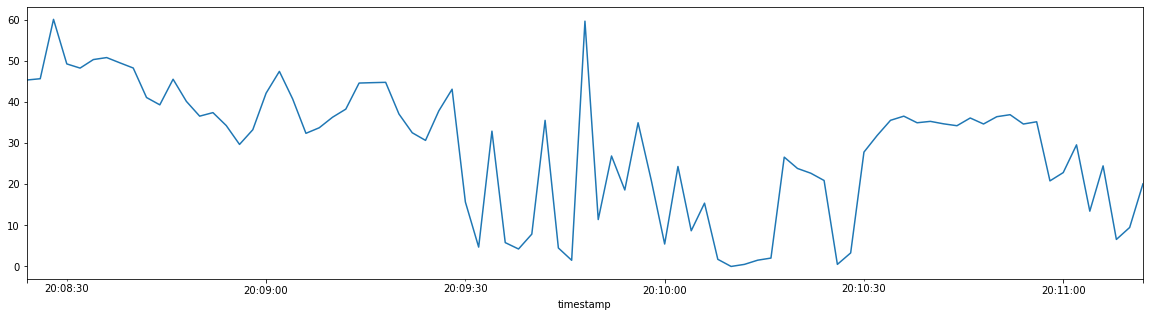

In [65]:
df_re.plot(figsize=(20,5))

## Distributed Inference

In [158]:
# Define the number of smaller chunks to split the DataFrame into
num_chunks = 20

# Calculate the size of each chunk
chunk_size = len(df) // num_chunks

# Split the DataFrame into smaller chunks
df_chunks = [df[i:i+chunk_size] for i in range(0, len(df), chunk_size)]

# Save each chunk as a separate CSV file
for i, chunk in enumerate(df_chunks):
    chunk.to_csv(f'./data/chunks/chunk_{i}.csv', index=False, header=False)

In [159]:
!aws s3 cp ./data/chunks/ s3://sagemaker-us-east-1-725069941408/ipinyou/chunked --recursive

upload: data/chunks/chunk_10.csv to s3://sagemaker-us-east-1-725069941408/ipinyou/chunked/chunk_10.csv
upload: data/chunks/chunk_15.csv to s3://sagemaker-us-east-1-725069941408/ipinyou/chunked/chunk_15.csv
upload: data/chunks/chunk_11.csv to s3://sagemaker-us-east-1-725069941408/ipinyou/chunked/chunk_11.csv
upload: data/chunks/chunk_13.csv to s3://sagemaker-us-east-1-725069941408/ipinyou/chunked/chunk_13.csv
upload: data/chunks/chunk_0.csv to s3://sagemaker-us-east-1-725069941408/ipinyou/chunked/chunk_0.csv
upload: data/chunks/chunk_16.csv to s3://sagemaker-us-east-1-725069941408/ipinyou/chunked/chunk_16.csv
upload: data/chunks/chunk_20.csv to s3://sagemaker-us-east-1-725069941408/ipinyou/chunked/chunk_20.csv
upload: data/chunks/chunk_14.csv to s3://sagemaker-us-east-1-725069941408/ipinyou/chunked/chunk_14.csv
upload: data/chunks/chunk_17.csv to s3://sagemaker-us-east-1-725069941408/ipinyou/chunked/chunk_17.csv
upload: data/chunks/chunk_12.csv to s3://sagemaker-us-east-1-725069941408/i

In [160]:
from sagemaker.tensorflow import TensorFlowProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput # processing inputs and output go in these fn

In [170]:
#Initialize the TensorFlowProcessor
tp = TensorFlowProcessor(
    framework_version='2.11',
    role=role,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    volume_size_in_gb=5,
    base_job_name='frameworkprocessor-TF',
    py_version='py39'
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


In [171]:

#Run the processing job
tp.run(
    code='inference-script.py',
    source_dir='code',
    inputs=[
        ProcessingInput(
            input_name='data',
            source=f's3://{bucket_name}/ipinyou/chunked/',
            destination='/opt/ml/processing/input/data'
        ),
        ProcessingInput(
            input_name='model',
            source=f's3://sagemaker-us-east-1-725069941408/tensorflow-training-2023-05-01-20-37-20-784/output/model.tar.gz',
            destination='/opt/ml/processing/input/model'
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name='predictions',
            source='/opt/ml/processing/output',
        )
    ]
)

INFO:sagemaker.processing:Uploaded code to s3://sagemaker-us-east-1-725069941408/frameworkprocessor-TF-2023-05-22-20-41-29-725/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-725069941408/frameworkprocessor-TF-2023-05-22-20-41-29-725/source/runproc.sh
INFO:sagemaker:Creating processing-job with name frameworkprocessor-TF-2023-05-22-20-41-29-725


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 501.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status '

In [173]:
tp.jobs[-1].describe()

{'ProcessingInputs': [{'InputName': 'data',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-725069941408/ipinyou/chunked/',
    'LocalPath': '/opt/ml/processing/input/data',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'model',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-725069941408/tensorflow-training-2023-05-01-20-37-20-784/output/model.tar.gz',
    'LocalPath': '/opt/ml/processing/input/model',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'code',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-725069941408/frameworkprocessor-TF-2023-05-22-20-41-29-725/source/sourcedir.tar.gz',
    'LocalPath': '/opt/ml/processing/input/code/',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File'

In [174]:
!aws s3 ls s3://sagemaker-us-east-1-725069941408/frameworkprocessor-TF-2023-05-22-20-41-29-725/output/predictions/

2023-05-22 20:47:39    4233894 output_algo-1.csv


In [175]:
#Initialize the TensorFlowProcessor
tp = TensorFlowProcessor(
    framework_version='2.11',
    role=role,
    instance_type='ml.m5.xlarge',
    instance_count=5,
    volume_size_in_gb=5,
    base_job_name='frameworkprocessor-TF',
    py_version='py39'
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


In [176]:
#Run the processing job
tp.run(
    code='inference-script.py',
    source_dir='code',
    inputs=[
        ProcessingInput(
            input_name='data',
            source=f's3://{bucket_name}/ipinyou/chunked/',
            destination='/opt/ml/processing/input/data',
            s3_data_distribution_type='ShardedByS3Key'
            
        ),
        ProcessingInput(
            input_name='model',
            source=f's3://sagemaker-us-east-1-725069941408/tensorflow-training-2023-05-01-20-37-20-784/output/model.tar.gz',
            destination='/opt/ml/processing/input/model'
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name='predictions',
            source='/opt/ml/processing/output',
        )
    ]
)

INFO:sagemaker.processing:Uploaded code to s3://sagemaker-us-east-1-725069941408/frameworkprocessor-TF-2023-05-22-20-48-57-166/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-725069941408/frameworkprocessor-TF-2023-05-22-20-48-57-166/source/runproc.sh
INFO:sagemaker:Creating processing-job with name frameworkprocessor-TF-2023-05-22-20-48-57-166


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [177]:
tp.jobs[-1].describe()

{'ProcessingInputs': [{'InputName': 'data',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-725069941408/ipinyou/chunked/',
    'LocalPath': '/opt/ml/processing/input/data',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'ShardedByS3Key',
    'S3CompressionType': 'None'}},
  {'InputName': 'model',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-725069941408/tensorflow-training-2023-05-01-20-37-20-784/output/model.tar.gz',
    'LocalPath': '/opt/ml/processing/input/model',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'code',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-725069941408/frameworkprocessor-TF-2023-05-22-20-48-57-166/source/sourcedir.tar.gz',
    'LocalPath': '/opt/ml/processing/input/code/',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',

In [178]:
!aws s3 ls s3://sagemaker-us-east-1-725069941408/frameworkprocessor-TF-2023-05-22-20-48-57-166/output/predictions/

2023-05-22 20:56:01    1034966 output_algo-1.csv
2023-05-22 20:56:05     829898 output_algo-2.csv
2023-05-22 20:56:00     827592 output_algo-3.csv
2023-05-22 20:56:00     553824 output_algo-4.csv
2023-05-22 20:56:15     826287 output_algo-5.csv


In [180]:
!aws s3 cp s3://sagemaker-us-east-1-725069941408/frameworkprocessor-TF-2023-05-22-20-48-57-166/output/predictions/output_algo-4.csv .

download: s3://sagemaker-us-east-1-725069941408/frameworkprocessor-TF-2023-05-22-20-48-57-166/output/predictions/output_algo-4.csv to ./output_algo-4.csv
